##Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##ResNet Implementation

### Load Dataset


torchvision 패키지에서 제공하는 STL-10

In [2]:
from torchvision import datasets
import torchvision.transforms as transforms
import os

path2data = '/data'

if  not os.path.exists(path2data):
  os.mkdir(path2data)

data_transformer = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.STL10(path2data, split='train', download='True', transform=data_transformer)
valid_ds = datasets.STL10(path2data, split='test', download='True', transform=data_transformer)

print(train_ds.data.shape)
print(valid_ds.data.shape)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting /data/stl10_binary.tar.gz to /data
Files already downloaded and verified
(5000, 3, 96, 96)
(8000, 3, 96, 96)


(3, 96, 96)


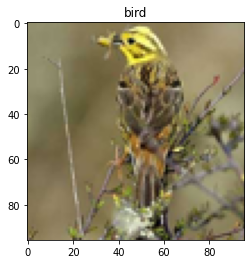

In [3]:
import matplotlib.pyplot as plt
import numpy as np

sample = train_ds.data[0]
print(sample.shape)
sample = np.transpose(sample, (1,2,0))
plt.title(train_ds.classes[train_ds.labels[0]])
plt.imshow(sample)

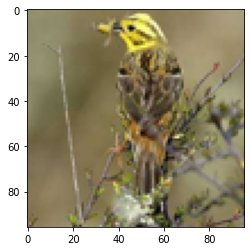

In [4]:
# train_ds에서 뽑은 tensor 데이터와 train_ds.data에서 뽑은 numpy 데이터 차이

data_sample = train_ds.data[0]
# print(data_sample)

for x, _ in train_ds:
  dataset_sample = x
  break
dataset_sample = dataset_sample.numpy()
dataset_sample = np.transpose(dataset_sample, (1,2,0))
# print(dataset_sample)
plt.imshow(dataset_sample)

##Data normalization

In [5]:
# normalize transformation을 적용하기 위해 평균, 표준편차 계산
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_ds]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_ds]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])

val_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in valid_ds]
val_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in valid_ds]

val_meanR = np.mean([m[0] for m in val_meanRGB])
val_meanG = np.mean([m[1] for m in val_meanRGB])
val_meanB = np.mean([m[2] for m in val_meanRGB])

val_stdR = np.mean([s[0] for s in val_stdRGB])
val_stdG = np.mean([s[1] for s in val_stdRGB])
val_stdB = np.mean([s[2] for s in val_stdRGB])

print(train_meanR, train_meanG, train_meanB)
print(val_meanR, val_meanG, val_meanB)

0.4467106 0.43980986 0.40664646
0.44723064 0.4396425 0.40495726


In [6]:
# transformation 객체 생성
from torch.utils.data import DataLoader

train_transformation = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize(224),
                        transforms.Normalize([train_meanR, train_meanG, train_meanB],[train_stdR, train_stdG, train_stdB]),
                        transforms.RandomHorizontalFlip(),
])

val_transformation = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize(224),
                        transforms.Normalize([train_meanR, train_meanG, train_meanB],[train_stdR, train_stdG, train_stdB]),
])

# apply transforamtion
train_ds.transform = train_transformation
valid_ds.transform = val_transformation

# create DataLoader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=32, shuffle=True)

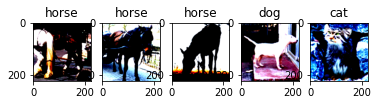

In [7]:
# check dataloader
for i in range(5):
  plt.subplot(1,5, i + 1)
  img, l = next(iter(train_dl))
  dp_img = np.transpose(img[i], (1,2,0))
  plt.title(train_ds.classes[l[i]])
  plt.imshow(dp_img)

### implementation

In [8]:
from torch.nn.modules.batchnorm import BatchNorm2d
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

class BasicBlock(nn.Module):
  expansion = 1
  def __init__(self, in_channels, out_channels, stride=1):
    super().__init__()

    self.residual_function = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False), # BatchNorm에 bias가 포함되어 있으므로 여기선 False
        nn.BatchNorm2d(out_channels), 
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(out_channels * BasicBlock.expansion)
    )

    self.shortcut = nn.Sequential()
    self.relu = nn.ReLU()

    # projection mapping using 1x1 conv
    if stride != 1 or in_channels != BasicBlock.expansion * out_channels: # stride가 1이 아니거나 입출력 채널이 서로 다를 때. stride 가 1이 아니면 왜?
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
          BatchNorm2d(out_channels * BasicBlock.expansion)
      )
    
    def forward(self, x):
      x = self.residual_function(x) + self.shortcut(x)
      x = self.relu(x)
      return (x)

In [9]:
class BottleNeck(nn.Module):
  expansion = 4 # resnet 50 이상부터 residual block 마지막 층에서 기존의 4배로 채널 확장
  def __init__(self, in_channels, out_channels, stride=1):
    super().__init__()

    self.residual_function = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=1, bias=False),
        nn.BatchNorm2d(out_channels * BottleNeck.expansion)      
    )

    self.shortcut = nn.Sequential()
    self.relu = nn.ReLU()

    if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(out_channels * BottleNeck.expansion)
      )

  def forward(self, x):
    x = self.residual_function(x) + self.shortcut(x)
    x = self.relu(x)
    return (x)

### Final Model

### 전체 구조

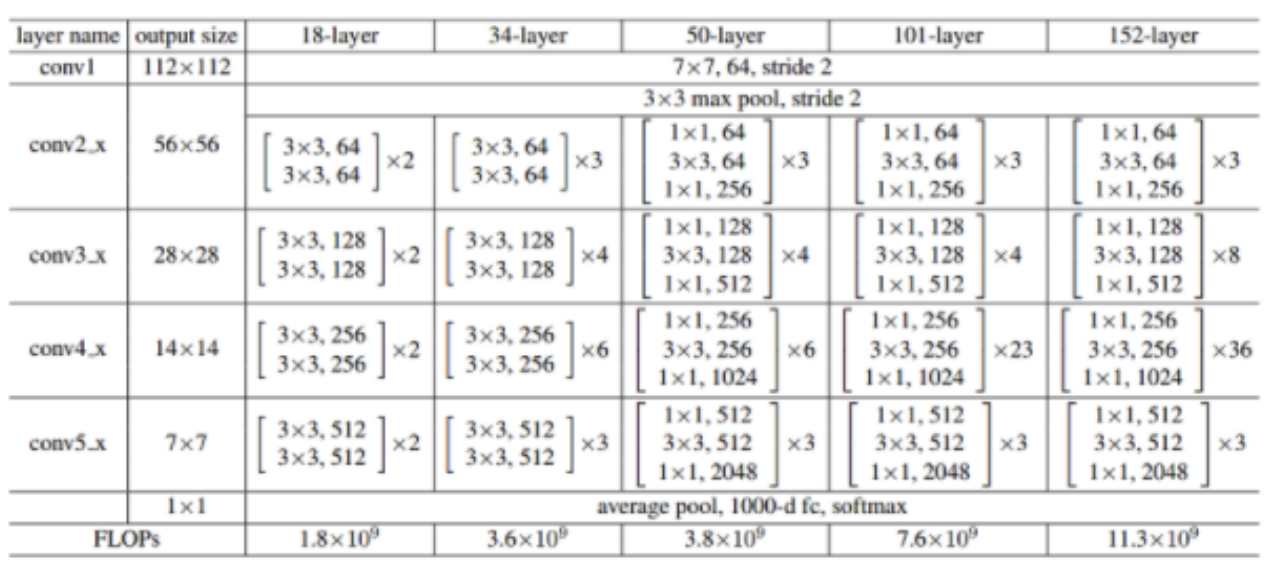

In [10]:
class ResNet(nn.Module):
  def __init__(self, block, num_block, num_classes=10):
    super().__init__()

    self.in_channels = 64
    self.conv1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    )

    self.conv2_x = self.resnet_layer(block, 64, num_block[0], 1)
    self.conv3_x = self.resnet_layer(block, 128, num_block[1], 2)
    self.conv4_x = self.resnet_layer(block, 256, num_block[2], 2)
    self.conv5_x = self.resnet_layer(block, 512, num_block[3], 2)

    self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(512 * block.expansion, num_classes)

  def resnet_layer(self, block, out_channels, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1) # [stride, 1, 1, .. 블록 개수] 형태의 배열
    layers = []
    for stride in strides:
      layers.append(block(self.in_channels, out_channels, stride))
      self.in_channels = out_channels * block.expansion

    return nn.Sequential(*layers) # list type의 layers를 unpacking 해서 nn.Sequential에 인자로 넘겨줌 - 인자 in_channels, out_channels, strides

  def forward(self, x):
    output = self.conv1(x)
    output = self.conv5_x(self.conv4_x(self.conv3_x(self.conv2_x(output))))
    output = self.avg_pool(output)
    # print("output shape : ", output.shape)
    output = output.view(output.size(0), -1) # 필터를 한줄로 펴고 그 필터가 채널의 개수만큼 겹쳐있는 형태
    # print("output shape : ", output.shape)
    output = self.fc(output)
    return (output)

  # define weight initialization function
  def _initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.constant_(m.bias, 0)

def resnet18():
  return ResNet(BasicBlock, [2,2,2,2])

def resnet34():
  return ResNet(BasicBlock, [3, 4, 6, 3])

def resnet50():
  return ResNet(BottleNeck, [3,4,6,3])

def resnet101():
  return ResNet(BottleNeck, [3, 4, 23, 3])

def resnet152():
  return ResNet(BottleNeck, [3, 8, 36, 3])

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet50().to(device)
x = torch.randn(10, 3, 224, 224).to(device)
output = model(x) # 각 batch 안 데이터 수, 예측 class의 label 형태의 출력
print(output.size())
print(model)

torch.Size([10, 10])
ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2_x): Sequential(
    (0): BottleNeck(
      (residual_function): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcu

### Training

In [12]:
from torch.optim.lr_scheduler import StepLR

loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.001)
lr_scheduler = StepLR(opt, step_size=10, gamma=0.1)

# hyper parameters
num_epochs = 20
optimizer = opt
loss_func = loss_func
train_dl = train_dl
val_dl = valid_dl
sanity_check = False
lr_scheduler = lr_scheduler
path2weights = '/content/drive/MyDrive/Colab_Notebooks/pytorch/code/implementation/models/resnet_weights.pt'

In [ ]:
import copy

loss_history = {'train': [], 'val': []}
best_loss = float('inf')
model.load_state_dict(torch.load(path2weights))
best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(num_epochs):
  model.train()

  running_loss = 0.0
  len_data = len(train_dl.dataset)

  for xb, yb in train_dl:
    xb = xb.to(device)
    yb = yb.to(device)
    output = model(xb)

    loss_b = loss_func(output, yb)
    opt.zero_grad()
    loss_b.backward()
    opt.step()

    running_loss += loss_b
    
  loss = running_loss / len_data
  loss_history['train'].append(loss)

  model.eval()
  with torch.no_grad():
    val_running_loss = 0.0
    for xb, yb in valid_dl:
      xb = xb.to(device)
      yb = yb.to(device)
      output = model(xb)

      loss_val = loss_func(output, yb)
      val_running_loss += loss_val
    val_loss = val_running_loss / len(valid_dl.dataset)
  
  if val_loss < best_loss:
    best_loss = best_loss
    best_model_wts = copy.deepcopy(model.state_dict())
    torch.save(model.state_dict(), path2weights)
    print('copied best model weights')
  loss_history['val'].append(val_loss)
  lr_scheduler.step()

print(loss)
model.load_state_dict(best_model_wts)

copied best model weights
copied best model weights
copied best model weights
copied best model weights
copied best model weights
copied best model weights
copied best model weights
copied best model weights
copied best model weights
copied best model weights
copied best model weights
copied best model weights
copied best model weights
copied best model weights
copied best model weights
copied best model weights
copied best model weights
copied best model weights
copied best model weights
copied best model weights
tensor(0.0040, device='cuda:0', grad_fn=<DivBackward0>)


<All keys matched successfully>

In [13]:
trained_model = resnet50().to(device)
trained_model.load_state_dict(torch.load(path2weights))
trained_model.eval()

img, label = next(iter(valid_dl))
inference_img = img[0]
real_label = train_ds.classes[label[0]]
print("real label : ", real_label)

x = torch.randn(1, 3, 224, 224).to(device)
x[0] = inference_img
inference_out = trained_model(x)
# print(inference_out)
best_index = inference_out.max(dim=1).indices.item()
plt.title(train_ds.classes[best_index])
plt.imshow(np.transpose(inference_img, (1,2,0)))

RuntimeError: ignored

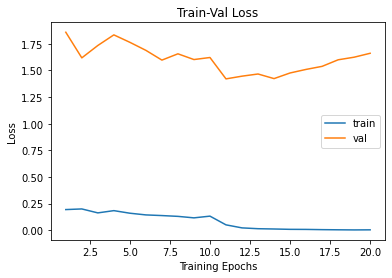

In [ ]:
plt.title("Train-Val Loss")
train_loss_list = []
val_loss_list = []
for sl in loss_history['train']:
  train_loss_list.append(sl.item())
for sl in loss_history['val']:
  val_loss_list.append(sl.item())
plt.plot(range(1,num_epochs+1),train_loss_list,label="train")
plt.plot(range(1,num_epochs+1), val_loss_list,label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()